In [2]:
import os
import pickle

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygmo as pg
import tellurium as te

os.chdir('..')

from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.odbm.odbm_main import ModelBuilder

In [6]:
os.getcwd()

'/home/mkcook/arpae/NEWBRENDA/ECFERS'

# Generate and read in an SBML file
### Only need to run once, but replace file names

In [8]:
r_base.exportToSBML('src/frenda_brenda/Files/SBML models/240603MC_base.sbml', current=False)

In [7]:
# Only need to run this the first time to make the model
model_species = pd.read_csv('src/frenda_brenda/Files/CCNs/SpeciesBaseMechanism_base.csv')
model_rxns = pd.read_csv('src/frenda_brenda/Files/CCNs/Reaction_base.csv')

modelfile = 'src/frenda_brenda/Files/SBML models/240603MC_base.txt'
myModel = ModelBuilder(model_species, model_rxns)
myModel.saveModel(modelfile)

with open('src/frenda_brenda/Files/SBML models/240603MC_base.txt', 'r') as f:
    antimony = f.read()
    
r_base  = te.loada(antimony)
r_base.exportToSBML('src/frenda_brenda/Files/SBML models/240603MC_base.sbml', current=False)

FileNotFoundError: [Errno 2] No such file or directory: 'ECFERS/src/frenda_brenda/Files/SBML models/240603MC_base.sbml'

### Run this if you just need to load in an existing SBML file

In [ ]:
# This is all you need to run in order to load in the SBML file
r = te.loads('src/frenda_brenda/Files/SBML models/240603MC_base.sbml')

# Perturb and repeatedly simulate an SBML model
### This code is for perturbing a compound

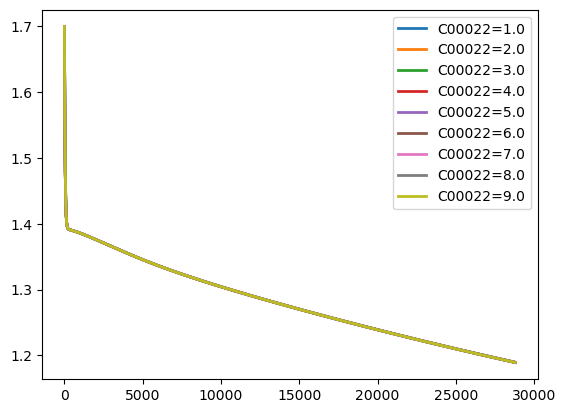

In [34]:
# Choose a substrate and iterate from start to end value (must be doubles) in increment values
for C00022 in np.arange(1.0, 10, 1):
    r_base.reset() # reset the SBML values each loop iteration
    r_base.C00022 = C00022 # assign chosen substrate/enzyme to newly perturbed value
    m = r_base.simulate (0, 28800, 1000, ['time', 'C00149']) # simulate model, this version specifies which values to take note of
    te.plotArray (m, show=False, labels=['C00022='+str(C00022)], resetColorCycle=False) # add that simulation to plot
te.show()

### This code is for perturbing an enzyme

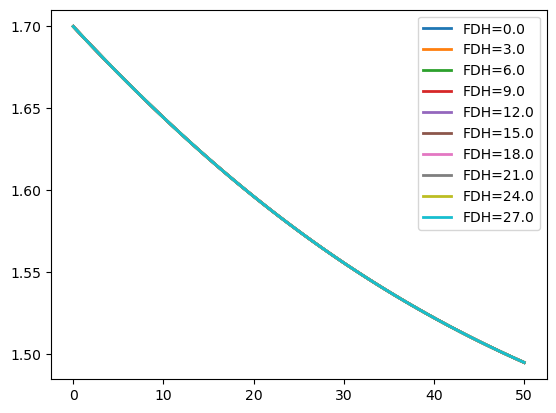

In [10]:
# Choose an EC ID and iterate from start to end value (must be doubles) in increment values
for EC11719 in np.arange(0.0, 30, 3):
    r_base.reset()
    r_base.EC11719 = EC11719
    m = r_base.simulate (0, 50, 100, ['time', 'C00149'])
    te.plotArray (m, show=False, labels=['FDH='+str(EC11719)], resetColorCycle=False)
te.show()

# Single simulation and kinetics visualization

In [31]:
# Simulate a given SBML model
result_base = r_base.simulate(0,10000, selections=['time','C00011', 'C00149']) # can remove selections and simulate whole model

In [32]:
# Choose values of model to pull and visualize 
time = result_base['time']
co2 = result_base['C00011']
mal = result_base['C00149']

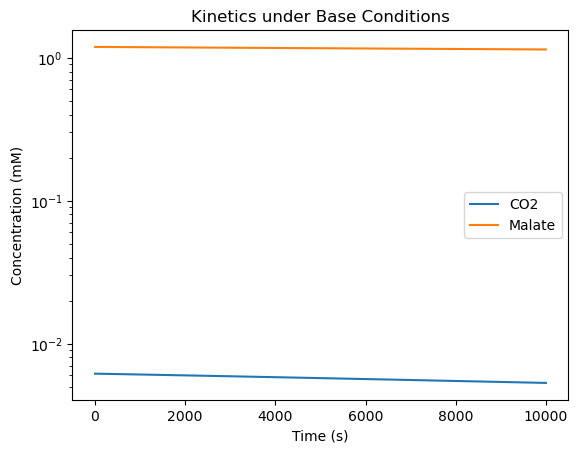

In [33]:
# Plotting code for a simple line graph
plt.plot(time, co2, label = "CO2")
plt.plot(time, mal, label = "Malate")
plt.yscale("log")
plt.legend()
plt.title("Kinetics under Base Conditions")
plt.xlabel("Time (s)")
plt.ylabel("Concentration (mM)")
plt.show()

# Generate heatmaps for flux through enzymes

In [16]:
kegg_labels = pd.read_csv('kegg_labels.csv', index_col = 0)
translate_kegg = lambda X: [kegg_labels.loc[x].values[0] for x in X]

In [17]:
# simulate an SBML model at 30, 60, 120, 240, and 480 minutes
r_base.reset()
r30 = r_base.simulate(0,1800)
rates30 = r_base.getReactionRates()

r_base.reset()
r60 = r_base.simulate(0,3600)
rates60 = r_base.getReactionRates()

r_base.reset()
r120 = r_base.simulate(0,7200)
rates120 = r_base.getReactionRates()

r_base.reset()
r240 = r_base.simulate(0,14400)
rates240 = r_base.getReactionRates()

r_base.reset()
r480 = r_base.simulate(0,28800)
rates480 = r_base.getReactionRates()

In [18]:
# find the indices for all reactions involving Malate (C00149)
r_met = np.where(np.abs(r_base.getFullStoichiometryMatrix()['C00149']))[0]

In [19]:
# index the rates at certain time points to get the rates of reactions involving malate
spec_rates30 = rates30[r_met]
spec_rates60 = rates60[r_met]
spec_rates120 = rates120[r_met]
spec_rates240 = rates240[r_met]
spec_rates480 = rates480[r_met]

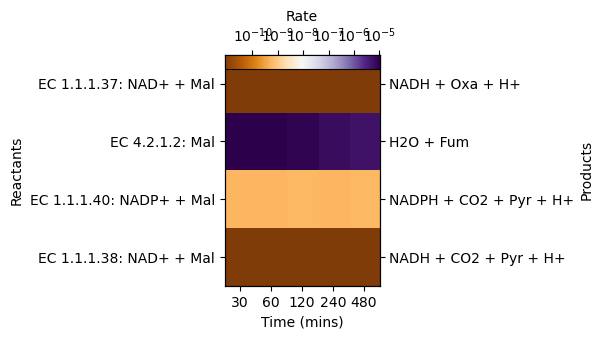

In [30]:
# Combine the arrays into a 2D array
reaction_rates = np.array([spec_rates30, spec_rates60, spec_rates120, spec_rates240, spec_rates480])

# Define time points in minutes
time_points = [30, 60, 120, 240, 480]

# Set up the figure size and subplot adjustments
size = np.ceil(len(r_met) / 3) + 1
fig, ax = plt.subplots(figsize=(2, size))
fig.subplots_adjust(wspace=0.5)

# Create the heatmap
im = ax.imshow(reaction_rates.T, aspect='auto', cmap='PuOr', norm=colors.SymLogNorm(1e-10))

# Set axis labels
ax.set_ylabel('Reactants')
ax.set_xlabel('Time (mins)')

# Set x-axis ticks and labels
ax.set_xticks(np.arange(len(time_points)))
ax.set_xticklabels(time_points)

# Optionally, add a secondary y-axis for additional labels (if needed)
ax.set_yticks(np.arange(0,len(r_met),1), labels = ['EC '+model_rxns.loc[model_rxns['Label'] == r]['EC'].values[0] +': '+' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Substrates'].values[0].replace(" ",'').split(';')))) for r in np.array(r_base.getReactionIds())[r_met]])
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(np.arange(0,len(r_met),1), labels = [' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Products'].values[0].replace(" ",'').split(';')))) for r in np.array(r_base.getReactionIds())[r_met]])
ax2.set_ylabel('Products')

# Add a colorbar on top with adjusted position
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('top', size='10%', pad='50%')  # Adjust pad to increase space between colorbar and heatmap

cbar = fig.colorbar(im, cax=cax2, orientation='horizontal', label='Rate')
cax2.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position('top')  # Move colorbar label to the top

# Show the plot
plt.show()

#Required to remove some white border